# 01 — Exploratory Data Analysis (EDA)

> **Objective:** To explore Vancouver Airbnb listing data, run sanity checks, and inform later SQL queries and Tableau dashboard design. This notebook is for EDA only — the final deliverables are SQL analytics and a Tableau dashboard.

This notebook outlines the following stages:
1. [**Setup**](#setup) — imports and pandas display options  
2. [**Load Data**](#load-data) — load listings (and reviews if present)  
3. [**Quick Data Audit**](#quick-data-audit) — dtypes, missing values, and price cleaning  
4. [**Core EDA Visuals**](#core-eda-visuals) — histograms, bar charts, box plots, scatter  
5. [**EDA Notes**](#eda-notes) — observations and questions for SQL  

> **Note:** Section links work in Jupyter or nbviewer; they may not render in static GitHub previews.

---
### 🧰 Setup <a id="setup"></a>

Imports and display options. Paths are resolved relative to the project root so the notebook works from any working directory (e.g. run from project root or from `notebooks/`).

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Resolve project root (works when run from project root or from notebooks/)
for candidate in [Path.cwd(), Path.cwd().parent]:
    if (candidate / "data" / "raw").exists():
        ROOT = candidate
        break
else:
    ROOT = Path.cwd()

DATA_RAW = ROOT / "data" / "raw"

# Pandas display options for readability
pd.set_option("display.max_columns", 50)
pd.set_option("display.width", 200)
pd.set_option("display.max_colwidth", 60)

### 📥 Load Data <a id="load-data"></a>

Load `listings.csv` and, if present, `reviews.csv`. Shapes and column lists are printed for a quick sanity check.

In [2]:
listings_path = DATA_RAW / "listings.csv"
df_listings = pd.read_csv(listings_path)

reviews_path = DATA_RAW / "reviews.csv"
if reviews_path.exists():
    df_reviews = pd.read_csv(reviews_path)
    print("Reviews loaded.")
else:
    df_reviews = None
    print("reviews.csv not found; skipping.")

print("\nListings shape:", df_listings.shape)
print("Listings columns:", list(df_listings.columns))
if df_reviews is not None:
    print("\nReviews shape:", df_reviews.shape)
    print("Reviews columns:", list(df_reviews.columns))

Reviews loaded.

Listings shape: (5685, 18)
Listings columns: ['id', 'name', 'host_id', 'host_name', 'neighbourhood_group', 'neighbourhood', 'latitude', 'longitude', 'room_type', 'price', 'minimum_nights', 'number_of_reviews', 'last_review', 'reviews_per_month', 'calculated_host_listings_count', 'availability_365', 'number_of_reviews_ltm', 'license']

Reviews shape: (309633, 2)
Reviews columns: ['listing_id', 'date']


### 📋 Quick Data Audit <a id="quick-data-audit"></a>

Inspect dtypes, missing value share per column (top 20), and basic summary stats. Clean `price` into a numeric column `price_num` if it contains symbols (e.g. `$`, `,`).

In [3]:
print("dtypes:")
print(df_listings.dtypes)

missing_pct = (df_listings.isna().sum() / len(df_listings) * 100).sort_values(ascending=False)
print("\nMissing value % (top 20 columns):")
print(missing_pct.head(20))

print("\nSummary stats:")
df_listings.describe(include="all")

dtypes:
id                                  int64
name                               object
host_id                             int64
host_name                          object
neighbourhood_group               float64
neighbourhood                      object
latitude                          float64
longitude                         float64
room_type                          object
price                             float64
minimum_nights                      int64
number_of_reviews                   int64
last_review                        object
reviews_per_month                 float64
calculated_host_listings_count      int64
availability_365                    int64
number_of_reviews_ltm               int64
license                            object
dtype: object

Missing value % (top 20 columns):
neighbourhood_group               100.000000
license                            23.236588
price                              18.715919
last_review                        14.652595
reviews

,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,number_of_reviews_ltm,license
count,5.685000e+03,5685,5.685000e+03,5685,0.0,5685,5685.000000,5685.000000,5685,4621.000000,5685.000000,5685.000000,4852,4852.000000,5685.000000,5685.000000,5685.000000,4364
unique,NaN,5608,NaN,2399,NaN,23,NaN,NaN,4,NaN,NaN,NaN,897,NaN,NaN,NaN,NaN,3500
top,NaN,Near UBC,NaN,Jordan,NaN,Downtown,NaN,NaN,Entire home/apt,NaN,NaN,NaN,2025-10-26,NaN,NaN,NaN,NaN,Municipal registration number: Exempt<br />Provincial re...
freq,NaN,9,NaN,175,NaN,1415,NaN,NaN,4527,NaN,NaN,NaN,139,NaN,NaN,NaN,NaN,174
mean,7.613445e+17,NaN,2.576343e+08,NaN,NaN,NaN,49.261296,-123.110926,NaN,192.000000,39.866843,54.464908,NaN,1.935876,9.758839,178.615655,15.014776,NaN
std,5.842027e+17,NaN,2.313810e+08,NaN,NaN,NaN,0.021467,0.040211,NaN,220.826095,49.219893,89.258061,NaN,1.876915,29.935776,125.371175,20.435971,NaN
min,1.318800e+04,NaN,6.033000e+03,NaN,NaN,NaN,49.202270,-123.223370,NaN,14.000000,1.000000,0.000000,NaN,0.010000,1.000000,0.000000,0.000000,NaN
25%,4.339090e+07,NaN,3.987119e+07,NaN,NaN,NaN,49.247790,-123.130661,NaN,97.000000,2.000000,3.000000,NaN,0.310000,1.000000,66.000000,0.000000,NaN
50%,9.101753e+17,NaN,2.045599e+08,NaN,NaN,NaN,49.267000,-123.112120,NaN,144.000000,3.000000,19.000000,NaN,1.450000,1.000000,175.000000,5.000000,NaN
75%,1.293822e+18,NaN,4.658082e+08,NaN,NaN,NaN,49.278892,-123.086070,NaN,213.000000,90.000000,71.000000,NaN,3.000000,4.000000,290.000000,24.000000,NaN


In [4]:
# Convert price to numeric if it's a string with symbols
if "price" in df_listings.columns:
    if pd.api.types.is_string_dtype(df_listings["price"]):
        df_listings["price_num"] = (
            df_listings["price"]
            .astype(str)
            .str.replace("$", "", regex=False)
            .str.replace(",", "", regex=False)
            .replace("", np.nan)
            .astype(float)
        )
    else:
        df_listings["price_num"] = pd.to_numeric(df_listings["price"], errors="coerce")
    print("price_num created. Sample:")
    print(df_listings[["price", "price_num"]].head(10))
else:
    print("No 'price' column found.")

price_num created. Sample:
   price  price_num
0  136.0      136.0
1  188.0      188.0
2    NaN        NaN
3   47.0       47.0
4  123.0      123.0
5   75.0       75.0
6   90.0       90.0
7    NaN        NaN
8    NaN        NaN
9  171.0      171.0


### 📊 Core EDA Visuals <a id="core-eda-visuals"></a>

Lightweight plots: price distribution (excluding extreme outliers), listings by neighbourhood, price by room type, price vs number of reviews; plus availability_365, minimum_nights, median price by neighbourhood, and room type counts.

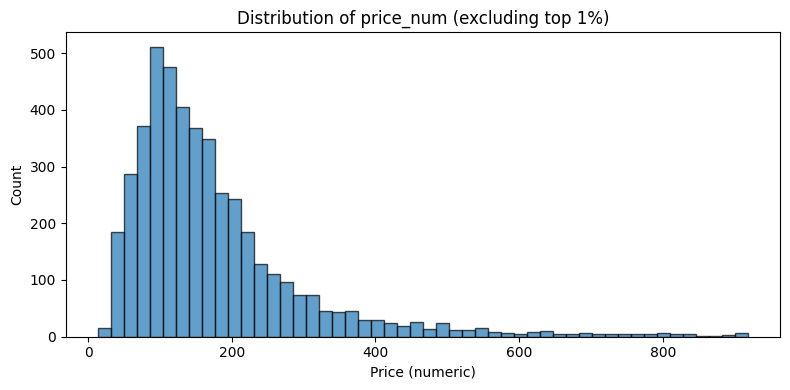

In [5]:
if "price_num" not in df_listings.columns:
    raise ValueError("Run the previous cell to create price_num.")

# Filter out top 1% of prices for histogram
cap = df_listings["price_num"].quantile(0.99)
price_filtered = df_listings.loc[df_listings["price_num"] <= cap, "price_num"]

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(price_filtered.dropna(), bins=50, edgecolor="black", alpha=0.7)
ax.set_xlabel("Price (numeric)")
ax.set_ylabel("Count")
ax.set_title("Distribution of price_num (excluding top 1%)")
plt.tight_layout()
plt.show()

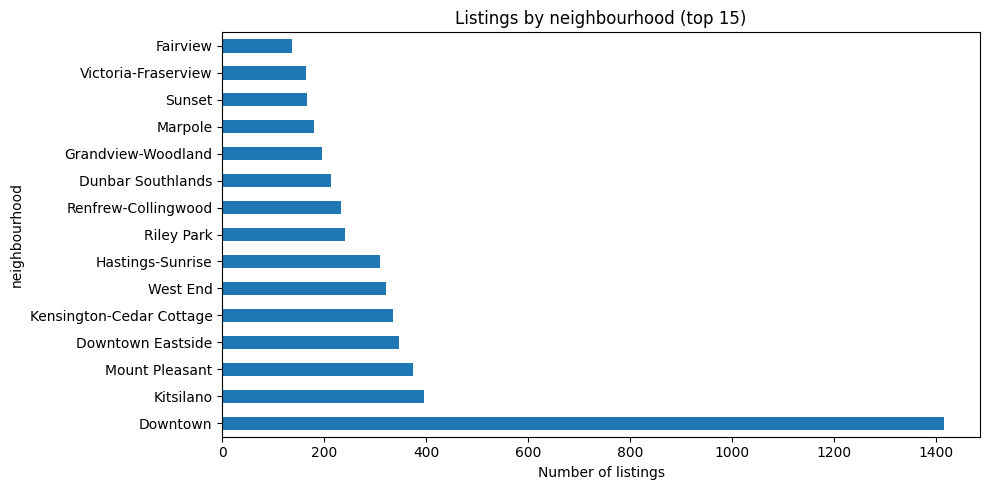

In [6]:
# Bar chart: number of listings by neighbourhood (top 15)
nbh_col = "neighbourhood" if "neighbourhood" in df_listings.columns else "neighbourhood_cleansed"
if nbh_col not in df_listings.columns:
    nbh_col = [c for c in df_listings.columns if "neighbour" in c.lower()][0] if any("neighbour" in c.lower() for c in df_listings.columns) else None
if nbh_col:
    top_nbh = df_listings[nbh_col].value_counts().head(15)
    fig, ax = plt.subplots(figsize=(10, 5))
    top_nbh.plot(kind="barh", ax=ax)
    ax.set_xlabel("Number of listings")
    ax.set_ylabel(nbh_col)
    ax.set_title("Listings by neighbourhood (top 15)")
    plt.tight_layout()
    plt.show()
else:
    print("No neighbourhood-like column found.")

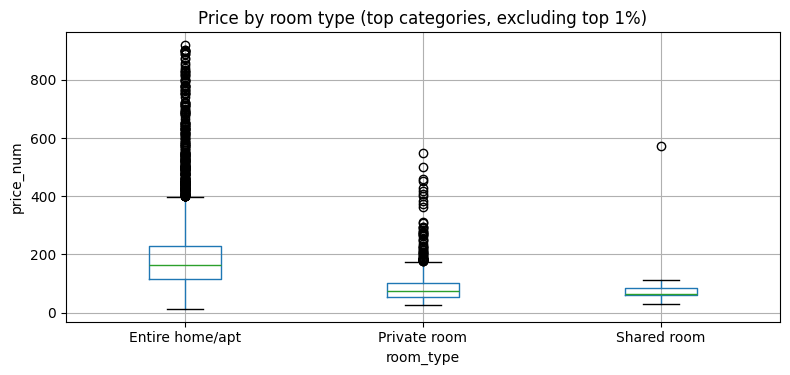

In [7]:
# Box plot: price_num by room type (top categories)
room_col = "room_type" if "room_type" in df_listings.columns else None
if room_col:
    top_rooms = df_listings[room_col].value_counts().head(6).index.tolist()
    subset = df_listings[df_listings[room_col].isin(top_rooms) & df_listings["price_num"].notna()]
    subset = subset[subset["price_num"] <= subset["price_num"].quantile(0.99)]
    fig, ax = plt.subplots(figsize=(8, 4))
    subset.boxplot(column="price_num", by=room_col, ax=ax)
    ax.set_xlabel(room_col)
    ax.set_ylabel("price_num")
    ax.set_title("Price by room type (top categories, excluding top 1%)")
    plt.suptitle("")
    plt.tight_layout()
    plt.show()
else:
    print("No 'room_type' column found.")

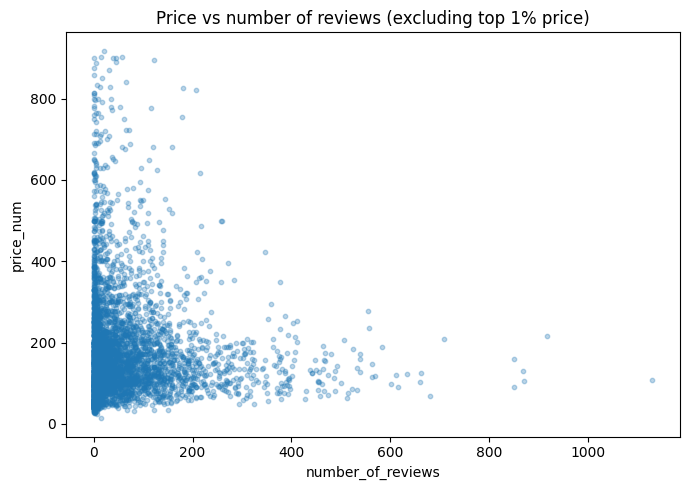

In [8]:
# Scatter: price_num vs number_of_reviews (if column exists)
if "number_of_reviews" in df_listings.columns:
    sub = df_listings[["price_num", "number_of_reviews"]].dropna()
    sub = sub[sub["price_num"] <= sub["price_num"].quantile(0.99)]
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.scatter(sub["number_of_reviews"], sub["price_num"], alpha=0.3, s=10)
    ax.set_xlabel("number_of_reviews")
    ax.set_ylabel("price_num")
    ax.set_title("Price vs number of reviews (excluding top 1% price)")
    plt.tight_layout()
    plt.show()
else:
    print("'number_of_reviews' column not found; skipping scatter.")

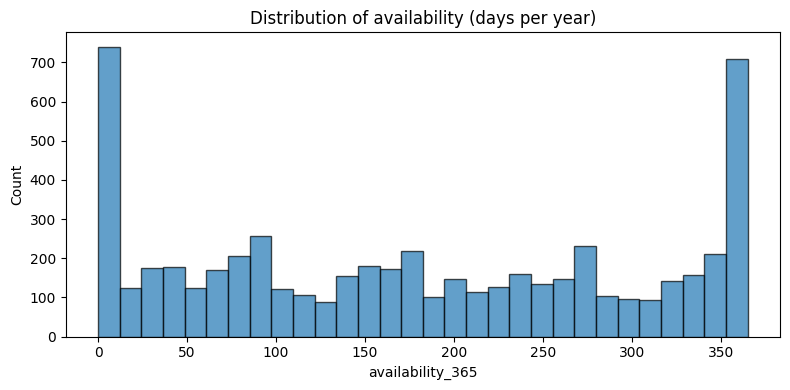

In [9]:
# Availability: distribution of days available per year
if "availability_365" in df_listings.columns:
    fig, ax = plt.subplots(figsize=(8, 4))
    ax.hist(df_listings["availability_365"].dropna(), bins=30, edgecolor="black", alpha=0.7)
    ax.set_xlabel("availability_365")
    ax.set_ylabel("Count")
    ax.set_title("Distribution of availability (days per year)")
    plt.tight_layout()
    plt.show()
else:
    print("'availability_365' not found.")

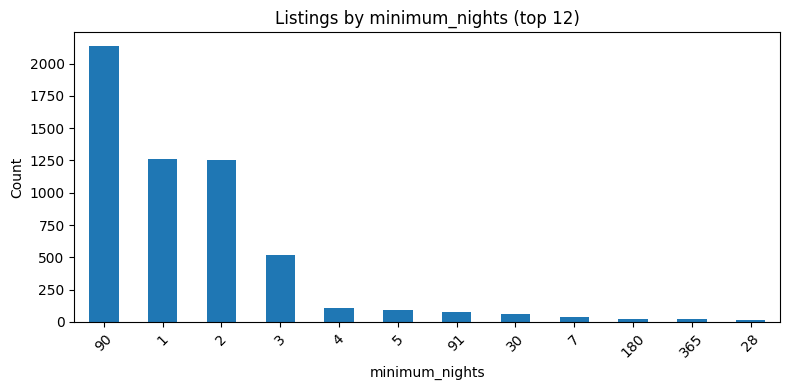

In [10]:
# Minimum nights: top values (cap long tail for readability)
if "minimum_nights" in df_listings.columns:
    top_min = df_listings["minimum_nights"].value_counts().head(12)
    fig, ax = plt.subplots(figsize=(8, 4))
    top_min.plot(kind="bar", ax=ax)
    ax.set_xlabel("minimum_nights")
    ax.set_ylabel("Count")
    ax.set_title("Listings by minimum_nights (top 12)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("'minimum_nights' not found.")

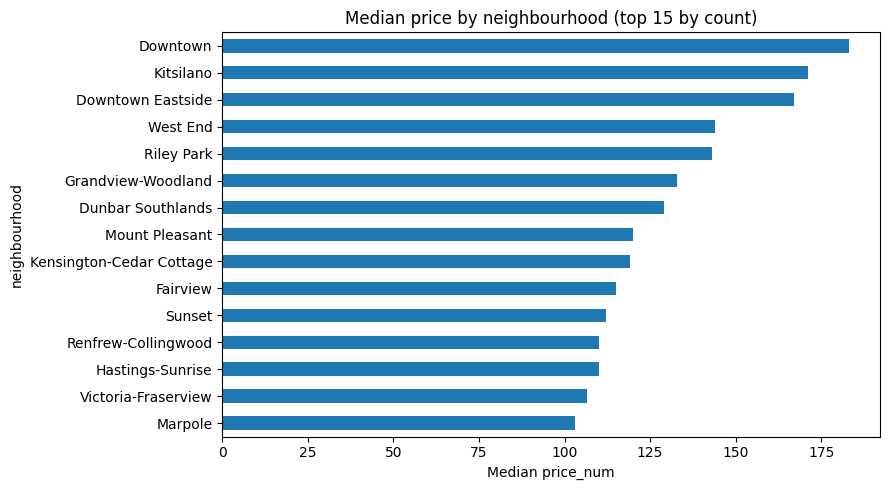

In [11]:
# Average price by neighbourhood (top 15 by listing count)
nbh_col = "neighbourhood" if "neighbourhood" in df_listings.columns else "neighbourhood_cleansed"
if nbh_col in df_listings.columns and "price_num" in df_listings.columns:
    top_nbh = df_listings[nbh_col].value_counts().head(15).index
    sub = df_listings[df_listings[nbh_col].isin(top_nbh)]
    avg_price = sub.groupby(nbh_col)["price_num"].median().sort_values(ascending=True)
    fig, ax = plt.subplots(figsize=(9, 5))
    avg_price.plot(kind="barh", ax=ax)
    ax.set_xlabel("Median price_num")
    ax.set_ylabel(nbh_col)
    ax.set_title("Median price by neighbourhood (top 15 by count)")
    plt.tight_layout()
    plt.show()
else:
    print("Neighbourhood or price_num column not found.")

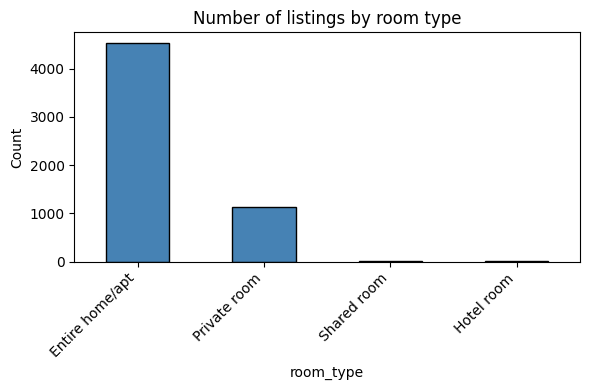

In [12]:
# Listings by room_type (counts)
if "room_type" in df_listings.columns:
    rt_counts = df_listings["room_type"].value_counts()
    fig, ax = plt.subplots(figsize=(6, 4))
    rt_counts.plot(kind="bar", ax=ax, color="steelblue", edgecolor="black")
    ax.set_xlabel("room_type")
    ax.set_ylabel("Count")
    ax.set_title("Number of listings by room type")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("'room_type' not found.")

---
### 📝 EDA Notes <a id="eda-notes"></a>

**Observations**
- Price is right-skewed; filtering the top 1% makes the distribution interpretable. Many listings cluster at lower price points.
- Listings are unevenly distributed across neighbourhoods; a few areas dominate by count. Median price varies clearly by neighbourhood — useful for the Tableau map.
- Room type (e.g. Entire home vs private room) drives price level; box plots show distinct tiers. Most listings are likely one or two room types.
- Availability (`availability_365`) and minimum nights vary a lot; some listings are nearly always available, others very restricted.
- Number of reviews and price show a weak relationship; high-review listings can sit at various price points (visibility vs price trade-off).
- `neighbourhood_group` is fully missing; use `neighbourhood` for geography. License and `last_review` have non-trivial missingness to handle in SQL.

**Questions to answer in SQL**
- Which neighbourhoods have the highest median or average price, and how many listings do they have?
- What is the distribution of room types by neighbourhood, and how does revenue (or occupancy) differ by room type?
- How do availability_365 and minimum_nights relate to price and review activity (e.g. always-available vs rarely-available)?
- Which hosts have the most listings (`calculated_host_listings_count`) and how do their prices compare to the market?
- For the dashboard: top N neighbourhoods by listing count and by median price; filters for room type and price range.